# Genshin Impact Reviews Analysis
## 4. Prediction Models
In this notebook, I will write the functions:
1. Predict whether a review is positive or negative 
2. Categorize the topic of the review based on the update version and whether it is positive or negative

# Import Libraries 

In [33]:
import pickle
import pandas as pd
import matplotlib.pyplot as plt

import tensorflow as tf
from tensorflow.keras.preprocessing.sequence import pad_sequences

import gensim, spacy
import gensim.corpora as corpora

import nltk
from nltk.corpus import wordnet
from nltk.corpus import stopwords
from nltk.tokenize import TweetTokenizer
from gensim.utils import simple_preprocess
from nltk.stem import WordNetLemmatizer

stop_words = set(stopwords.words('english'))
stop_words.update(["game", "just", "play", "would", "could"])

# Load Models

## LSTM Model

In [2]:
with open('models/LSTM_model_tokenizer.pkl', 'rb') as f:
    data = pickle.load(f)
    new_tokenizer = data['tokenizer']
    vocab_size = data['vocab_size']
    max_len = data['max_len']
    
new_model = tf.keras.models.load_model('models/LSTM_model')

In [3]:
def predict_pos_neg(review, threshold = 0.1):
    
    review = [review]

    padded_review = pad_sequences(new_tokenizer.texts_to_sequences(review), maxlen = max_len)
    
    pred = new_model.predict(padded_review)[0][1]
    
    if pred < 0.5 - threshold:
        return ('negative', pred)
    
    elif pred > 0.5 + threshold:
        return ('positive', pred)
    
    else:
        return ('neutral', pred)

## LDA Model

In [4]:
model_112_pos = {'model': gensim.models.LdaModel.load('models/112_pos.model'),
                'id2word': corpora.Dictionary.load('models/112_pos.model.id2word')}

model_112_neg = {'model': gensim.models.LdaModel.load('models/112_neg.model'),
                'id2word': corpora.Dictionary.load('models/112_neg.model.id2word')}

model_111_pos = {'model': gensim.models.LdaModel.load('models/111_pos.model'),
                'id2word': corpora.Dictionary.load('models/111_pos.model.id2word')}

model_111_neg = {'model': gensim.models.LdaModel.load('models/111_neg.model'),
                'id2word': corpora.Dictionary.load('models/111_neg.model.id2word')}

model_102_pos = {'model': gensim.models.LdaModel.load('models/102_pos.model'),
                'id2word': corpora.Dictionary.load('models/102_pos.model.id2word')}

model_102_neg = {'model': gensim.models.LdaModel.load('models/102_neg.model'),
                'id2word': corpora.Dictionary.load('models/102_neg.model.id2word')}

model_101_pos = {'model': gensim.models.LdaModel.load('models/101_pos.model'),
                'id2word': corpora.Dictionary.load('models/101_pos.model.id2word')}

model_101_neg = {'model': gensim.models.LdaModel.load('models/101_neg.model'),
                'id2word': corpora.Dictionary.load('models/101_neg.model.id2word')}

model_112 = {'pos': model_112_pos,
             'neg': model_112_neg}

model_111 = {'pos': model_111_pos,
             'neg': model_111_neg}

model_102 = {'pos': model_102_pos,
             'neg': model_102_neg}

model_101 = {'pos': model_101_pos,
             'neg': model_101_neg}

model_dict = {'112': model_112,
              '111': model_111,
              '102': model_102,
              '101': model_101}

In [5]:
topics_112_pos = {0: 'Suggestions',
                  1: 'Character System',
                  2: 'Technical Issues',
                  3: 'Love for Game'}

topics_112_neg = {0: 'Complaints on Game Systems',
                  1: 'Account Security Issues',
                  2: 'Technical Issues'}

topics_111_pos = {0: 'Love for Game (Graphics)',
                  1: 'Love for Game (Free Mobile RPG)',
                  2: 'Character System',
                  3: 'Technical Issues'}

topics_111_neg = {0: 'Technical Issues (Bugs & Lags)',
                  1: 'Storage Issues',
                  2: 'Complaints on Game Systems',
                  3: 'Technical Issues (Mobile Optimization & Account Security)'}

topics_102_pos = {0: 'Love for Game (Graphics)',
                  1: 'Character System',
                  2: 'Love for Game (Mobile RPG)',
                  3: 'Technical Issues'}

topics_102_neg = {0: 'Control Issues',
                  1: 'Technical Issues',
                  2: 'Complaints on Game Systems (Character Rates)',
                  3: 'Complaints on Game Systems (Resin Systems)'}


topics_101_pos = {0: 'Love for Game (Free Mobile RPG)',
                  1: 'Praises & Anticipation',
                  2: 'Technical Issues',
                  3: 'Love for Game (Graphics)'}

topics_101_neg = {0: 'Technical Issues (Bugs, Crash and Lags)',
                  1: 'Complaints on Game Systems',
                  2: 'Technical Issues (Bad Mobile Performance)'}

topics_112 = {'pos': topics_112_pos,
              'neg': topics_112_neg}

topics_111 = {'pos': topics_111_pos,
              'neg': topics_111_neg}

topics_102 = {'pos': topics_102_pos,
              'neg': topics_102_neg}

topics_101 = {'pos': topics_101_pos,
              'neg': topics_101_neg}

topics_dict = {'112': topics_112,
               '111': topics_111,
               '102': topics_102,
               '101': topics_101}

In [6]:
# tweet tokenizer
def get_sent_post(sentence):
    word_tag = nltk.pos_tag(sentence)

    new_word_tag = []

    for word, tag in word_tag:
        new_tag = tag[0]
        tag_dict = {"J": wordnet.ADJ,
                    "N": wordnet.NOUN,
                    "V": wordnet.VERB,
                    "R": wordnet.ADV}

        new_word_tag.append((word, tag_dict.get(new_tag, wordnet.NOUN)))
    
    return new_word_tag

def process_words(data, stop_words_list = stop_words, allowed_postags=['NOUN', 'ADJ', 'VERB', 'ADV', 'PROPN']):
    """Remove Stopwords, Form Bigrams, Trigrams and Lemmatization"""
    
    tokenizer = TweetTokenizer()
    texts = [tokenizer.tokenize(doc) for doc in data]
    
    # build the bigram and trigram models by automatically detecting common phrases / multiword expressions
    # min_count ignores all words and bigrams with total count less than the number
    # threshold affects the number of phrases that will be created (higher threshold = fewer phrases)
    bigram = gensim.models.Phrases(texts, min_count=5, threshold=100)
    trigram = gensim.models.Phrases(bigram[texts], threshold=100)

    # a phrases object is for learning bigrams (and multiword expressions), not for processing
    # for processing, need to use a phraser object
    bigram_mod = gensim.models.phrases.Phraser(bigram)
    trigram_mod = gensim.models.phrases.Phraser(trigram)
    
    # removes stopwords, lowercases, tokenizes, de-accents and 
    # removes words that are too short or too long in the text if word not in stop_words
    texts = [[word for word in simple_preprocess(str(doc), deacc=True) if word not in stop_words_list] for doc in texts]
 
    # combines bi-gram phrases
    texts = [bigram_mod[doc] for doc in texts]
    
    # combines tri-gram phrases
    texts = [trigram_mod[bigram_mod[doc]] for doc in texts]
    
    texts_out = []
    
    # loads the spacy 'en_core_web_sm' model to get the type of pos tags for each word
    # disabling 'parser' and 'ner' for faster processing (keeping only tagger component)
    nlp = spacy.load('en_core_web_sm', disable=['parser', 'ner'])
    
    for sent in texts:
        
        # join the words together and process the it using the nlp model
        doc = nlp(" ".join(sent)) 
        
        # only keep the word if it is in the allowed pos tags
        texts_out.append([token for token in doc if token.pos_ in allowed_postags])
    

    # using NLTK's lemmatizer as it returns words into their base forms
    # it performs better than many other lemmatizer (and stemmers) as it takes into account the part-of-speech of the word
    texts_out = [[word for word in simple_preprocess(str(doc))] for doc in texts_out]

    lemmatizer = WordNetLemmatizer()
    texts_out = [[lemmatizer.lemmatize(word, pos) for word, pos in get_sent_post(sentence)] for sentence in texts_out]
    
    # remove stopwords again after lemmatizing
    texts_out = [[word for word in doc if word not in stop_words_list] for doc in texts_out]
        
    return texts_out

In [7]:
def predict_topic(review, update, pos_neg, threshold = 0.1):
    
    processed_sentence = process_words(pd.Series(review))
    
    sentence_bow = model_dict[update][pos_neg]['id2word'].doc2bow(processed_sentence[0])
    
    sentence_pred = model_dict[update][pos_neg]['model'].get_document_topics(sentence_bow)
    sentence_pred.sort(key=lambda tup: tup[1], reverse = True)
    
    top_2_topics = [(topics_dict[update][pos_neg][tup[0]], tup[1]) for tup in sentence_pred[:2]]
    
    if top_2_topics[0][1] - top_2_topics[1][1] < threshold:
        return [tup[0] for tup in top_2_topics]
    
    else:
        return top_2_topics[0][0]

# Testing Prediction Functions

## Neutral Reviews

In [8]:
neu_line = """
The game is truly one of the best in it's genre. the world is fun to explore, the combat is quite engaging! 
The biggest issue, I have with this game is The Resin System! 
It feels too restrictive, and heavily halts the players progression in becoming stronger and upgrading their characters. 
All the fun content requires you to have resin, and there's not enough ways to refill resin Reasonably. 
I often end my play sessions unsatifised because I just wanted to play and farm a bit more
"""

In [9]:
predict_pos_neg(neu_line)

('neutral', 0.51674)

In [10]:
predict_pos_neg(neu_line, threshold = 0)

('positive', 0.51674)

In [11]:
predict_topic(neu_line, update = '112', pos_neg = 'pos')

['Character System', 'Suggestions']

## Positive Reviews

In [12]:
pos_line = """
The game is truly one of the best in it's genre. the world is fun to explore, the combat is quite engaging! 
"""

In [13]:
predict_pos_neg(pos_line)

('positive', 0.9994367)

In [14]:
predict_topic(pos_line, update = '112', pos_neg = 'pos')

'Love for Game'

## Negative Reviews

In [15]:
neg_line = """
The biggest issue, I have with this game is The Resin System! 
It feels too restrictive, and heavily halts the players progression in becoming stronger and upgrading their characters. 
All the fun content requires you to have resin, and there's not enough ways to refill resin Reasonably. 
I often end my play sessions unsatifised because I just wanted to play and farm a bit more
"""

In [16]:
predict_pos_neg(neg_line)

('negative', 0.10333362)

In [17]:
predict_topic(neg_line, update = '112', pos_neg = 'neg')

'Complaints on Game Systems'

## Other Reviews

In [18]:
review_1 = "I wish I could give this game more stars. This game is beyond excellent! There is not one bad thing I can say about this game, it is everything I have ever wanted in a mobile game. I'm addicted to it and love the cute anime style!!"

# Predicting Positive/Negative Class of 3 Stars Reviews

In [19]:
df = pd.read_pickle('data/final_df.p')

In [20]:
df = df[df['score'] ==  3].copy()

In [21]:
df.head()

,content,score,date,thumbsUp,source,text,length,update
6,This game is pretty great. Until you hit late ...,3,2020-12-15 21:34:40,7.0,google_play_store,"[this, game, is, pretty, great, until, you, hi...",87,1.1.2
33,"I love this game so SO much, but the in-game b...",3,2020-12-15 11:56:52,3.0,google_play_store,"[i, love, this, game, so, so, much, but, the, ...",87,1.1.2
43,Absolutely loved this game but after recent up...,3,2020-12-16 09:31:32,0.0,google_play_store,"[absolutely, loved, this, game, but, after, re...",66,1.1.2
45,•I love this game 💕 •It has nice character des...,3,2020-12-16 03:03:41,0.0,google_play_store,"[i, love, this, game, it, has, nice, character...",95,1.1.2
46,"This game is awesome, has very good graphics, ...",3,2020-12-12 13:28:17,3.0,google_play_store,"[this, game, is, awesome, has, very, good, gra...",61,1.1.2


In [23]:
reviews = df['content'].values

In [25]:
df['prediction'] = df['content'].apply(lambda x: predict_pos_neg(x))

In [26]:
df.head()

,content,score,date,thumbsUp,source,text,length,update,prediction
6,This game is pretty great. Until you hit late ...,3,2020-12-15 21:34:40,7.0,google_play_store,"[this, game, is, pretty, great, until, you, hi...",87,1.1.2,"(negative, 0.018574368)"
33,"I love this game so SO much, but the in-game b...",3,2020-12-15 11:56:52,3.0,google_play_store,"[i, love, this, game, so, so, much, but, the, ...",87,1.1.2,"(negative, 0.091435134)"
43,Absolutely loved this game but after recent up...,3,2020-12-16 09:31:32,0.0,google_play_store,"[absolutely, loved, this, game, but, after, re...",66,1.1.2,"(negative, 0.037287418)"
45,•I love this game 💕 •It has nice character des...,3,2020-12-16 03:03:41,0.0,google_play_store,"[i, love, this, game, it, has, nice, character...",95,1.1.2,"(negative, 0.39537132)"
46,"This game is awesome, has very good graphics, ...",3,2020-12-12 13:28:17,3.0,google_play_store,"[this, game, is, awesome, has, very, good, gra...",61,1.1.2,"(neutral, 0.42219338)"


In [27]:
for i in range(10):
    print(df['content'].iloc[i], df['prediction'].iloc[i])

This game is pretty great. Until you hit late game and realize the problems with it. The resin system is terrible, gates progression, and they want to keep it for money reasons. Honestly this game will make more than enough(if not more) money without it. The security issues without two factor authentication also prevents me from spending money on this game. If they removed the resin system and increased security I would spend more money than I do on most games because of the quality content. ('negative', 0.018574368)
I love this game so SO much, but the in-game bugs and glitches keep ruining the experience for me. Everytime Stormterror keeps coming into the frame, there is almost *nothing* I could see except glitching textures. I also cannot aim as Amber so I had to keep going out of aiming mode to aim properly. Cutscenes tend to stutter every now and then as well. I'm still in the prologue and I literally cannot progress when these issues are in the way. Please fix this. ('negative', 

In [28]:
df['pos_neg'] = df['prediction'].apply(lambda x: x[0])

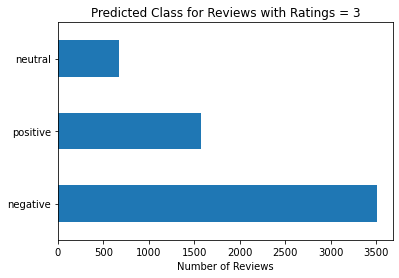

In [34]:
df['pos_neg'].value_counts().plot(kind = 'barh')
plt.title('Predicted Class for Reviews with Ratings = 3')
plt.xlabel('Number of Reviews')
plt.show()